In [2]:
!pip install mysql-connector-python matplotlib pandas

In [2]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# ***Analizando las defunciones por sexo y por entidad***
Se utilizará de la página del Sistema de Información de la Secretaría de Salud [DGIS](http://sinaiscap.salud.gob.mx:8080/DGIS/) un tablero de defunciones por año y por sexo en el país, específicamente, el tablero se encuentra en [tablero](http://sinaiscap.salud.gob.mx:8080/DGIS/GenerarTabla?titulo=Defunciones%20por%20sexo%20por%20a%F1o&href=/tablero/defunciones/defunciones_sexo_porentidad/1998-2022_defunciones_sexo_porentidad.xlsx&ruta=/tablero/defunciones/defunciones_sexo_porentidad/1998-2022_defunciones_sexo_porentidad.xlsx&hoja=Nacional&adicionalesTitulo=NACIONAL).
Primeramente, se descargó el archivo .xlsx, se convirtió a .csv, y con ayuda de MySQL Workbench lo convertimos a una tabla en una base de datos, es por eso que a continuación se muestra la conexión a nuestra base de datos

## Conexión a la base de datos

In [3]:
def connect_to_db():
    return mysql.connector.connect(
        host="localhost",
        user="root",
        password="JSLGKGM081022",
        database="proyecto"
    )

## Realizar una consulta y devolver los datos en un DataFrame de pandas

In [4]:
def fetch_data(query):
    connection = connect_to_db()
    cursor = connection.cursor()
    cursor.execute(query)
    data = cursor.fetchall()
    columns = [col[0] for col in cursor.description]
    df = pd.DataFrame(data, columns=columns)
    cursor.close()
    connection.close()
    return df

## Verificamos la conexión

In [5]:
import mysql.connector
from mysql.connector import Error

def test_connection():
    connection = None  # Definir la variable connection fuera del bloque try
    try:
        connection = mysql.connector.connect(
            host="localhost",
            user="root",
            password="JSLGKGM081022",
            database="proyecto"
        )
        if connection.is_connected():
            print("Conexión exitosa")
    except Error as err:
        print(f"Error: {err}")
    finally:
        if connection is not None and connection.is_connected():
            connection.close()
            print("Conexión cerrada")

test_connection() 

Conexión exitosa
Conexión cerrada


## Importamos la tabla de datos

In [23]:
query = "SELECT * FROM defunciones_sexo_porentidad"

data_df = fetch_data(query)
data_df

,Año,Entidad_Federativa,Hombre,Mujer,NE,Total
0,2022-01-01,Nacional,466786,368395,252,835433
1,2022-01-01,Aguascalientes,4469,3612,0,8081
2,2022-01-01,Baja California,15286,9338,69,24693
3,2022-01-01,Baja California Sur,2584,1718,0,4302
4,2022-01-01,Campeche,3183,2503,1,5687
...,...,...,...,...,...,...
820,1998-01-01,Tamaulipas,6577,4964,7,11548
821,1998-01-01,Tlaxcala,2348,2007,1,4356
822,1998-01-01,Veracruz,18232,14175,17,32424
823,1998-01-01,YucatÃ¡n,4501,3816,1,8318


## **Manipulación de los datos**

Mostraremos el tipo de datos que contiene la tabla, esto se logra mediante el siguiente código, de la salida observamos que sólo tenemos una variable cualitativa, la cual es **Entidad Federativa**.



In [11]:
# Mostrar información sobre los tipos de datos
print("Tipo de datos del DataFrame:")

query = "DESCRIBE defunciones_sexo_porentidad"
df = fetch_data(query)
df

Tipo de datos del DataFrame:


,Field,Type,Null,Key,Default,Extra
0,Año,datetime,YES,,None,
1,Entidad_Federativa,text,YES,,None,
2,Hombre,int,YES,,None,
3,Mujer,int,YES,,None,
4,NE,int,YES,,None,
5,Total,int,YES,,None,


Ahora, filtraremos los datos para un solo año (2022) y para un estado solamente (Sonora)

In [24]:
# Filtrar datos para el año 2022 y el estado de Sonora
query = "SELECT * FROM defunciones_sexo_porentidad WHERE YEAR(Año) = 2022 AND `Entidad_Federativa` = 'Sonora'"

df_sonora_2022 = fetch_data(query)
df_sonora_2022

,Año,Entidad_Federativa,Hombre,Mujer,NE,Total
0,2022-01-01,Sonora,13005,8704,12,21721


Como podemos observar, nuestro DataFrame contiene la cantidad de Hombres, Mujeres y No Especificados que murieron en el estado de Sonora en el año 2022.

El siguiente paso ahora es, modificar ciertos valores de nuestra variable cualitativa **Entidad Federativa**, en los cuales no se reconocieron los acentos, etc.

In [25]:
data_df['Entidad_Federativa'] = data_df['Entidad_Federativa'].replace({'MÃ©xico':'Estado de Mexico', 'MichoacÃ¡n': 'Michoacan', 'Nuevo LeÃ³n':'Nuevo Leon', 'QuerÃ©taro':'Queretaro','San Luis PotosÃ­':'San Luis Potosi', 'YucatÃ¡n':'Yucatan'})
data_df.head(33)

,Año,Entidad_Federativa,Hombre,Mujer,NE,Total
0,2022-01-01,Nacional,466786,368395,252,835433
1,2022-01-01,Aguascalientes,4469,3612,0,8081
2,2022-01-01,Baja California,15286,9338,69,24693
3,2022-01-01,Baja California Sur,2584,1718,0,4302
4,2022-01-01,Campeche,3183,2503,1,5687
5,2022-01-01,Coahuila,11650,9553,6,21209
6,2022-01-01,Colima,3475,2206,2,5683
7,2022-01-01,Chiapas,17389,14314,3,31706
8,2022-01-01,Chihuahua,16990,11806,28,28824
9,2022-01-01,CDMX,35782,33669,4,69455


## **Análisis exploratorio básico**
Realizaremos un análisis exploratorio básico, incluyendo gráficos y agrupaciones.

En primera instancia, vamos a agrupar por entidad federativa los datos del año 2022, y con el total de casos por entidad, realizaremos una gráfiva de barras horizontal, ordenandolas de manera descendente. Esta gráfica nos permitirá observar en que estados hubo más y menos decesos en ese año.


In [52]:
# Análisis exploratorio básico

# Configuraciones de visualización
sns.set_theme()
plt.rcParams["figure.figsize"] = (12, 6)

# 1. Total de casos por entidad en 2022
query = "SELECT `Entidad_Federativa`, SUM(`Total`) AS Total_Casos FROM defunciones_sexo_porentidad WHERE YEAR(`Año`) = 2022 GROUP BY `Entidad_Federativa` ORDER BY Total_Casos"
total_por_entidad = fetch_data(query)
# convertimos a tipo int64 el total de los casos para que podamos hacer la gráfica
total_por_entidad['Total_Casos'] = total_por_entidad['Total_Casos'].astype('int64')

In [58]:
# Graficar
# Definir una paleta de colores personalizada
colores = sns.color_palette("hls", len(total_por_entidad))
total_por_entidad.plot(kind='barh', title='Total de Casos por Entidad Federativa en 2022', color=colores)
plt.xlabel('Total de Casos')
plt.ylabel('Entidad Federativa')
plt.close()

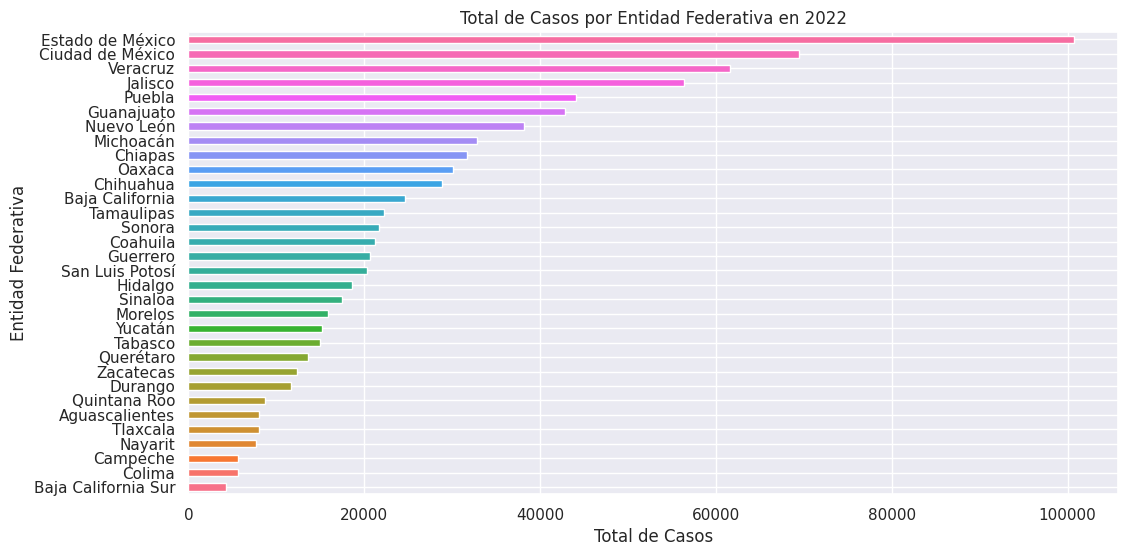

Como podemos observar, el estado en el que hay menos decesos es Baja California Sur, y el que más hay desesos es Estado de México. Sin embargo, el estado que nos interesa en este análisis es Sonora, en el cuál observamos una cantidad de defunciones un poco mayor a 20,000 en el año 2022. De ese total, ¿Qué proporción fueron hombres y qué proporción fueron mujeres?.

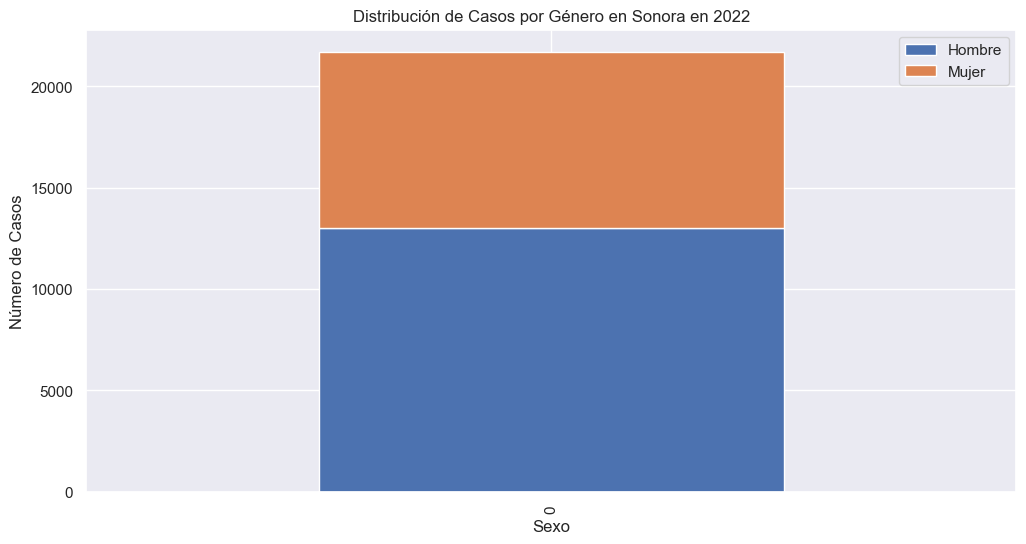

In [60]:
# 2. Distribución de casos por género en Sonora en 2022
df_sonora_2022[['Hombre', 'Mujer']].plot(kind='bar', stacked=True, title='Distribución de Casos por Género en Sonora en 2022')
plt.xlabel('Sexo')
plt.ylabel('Número de Casos')
plt.show()

Como se observa, en Sonora, 2022, hubieron más defunciones de hombres que de mujeres.

Por último, es de nuestro interés, saber la evolución de los casos de muerte en Sonora, a través de los años, es por ello que mediante una agrupación de la base de datos total por año en donde la entidad federativa es Sonora, se gráfica la serie de tiempo de esta evolución;

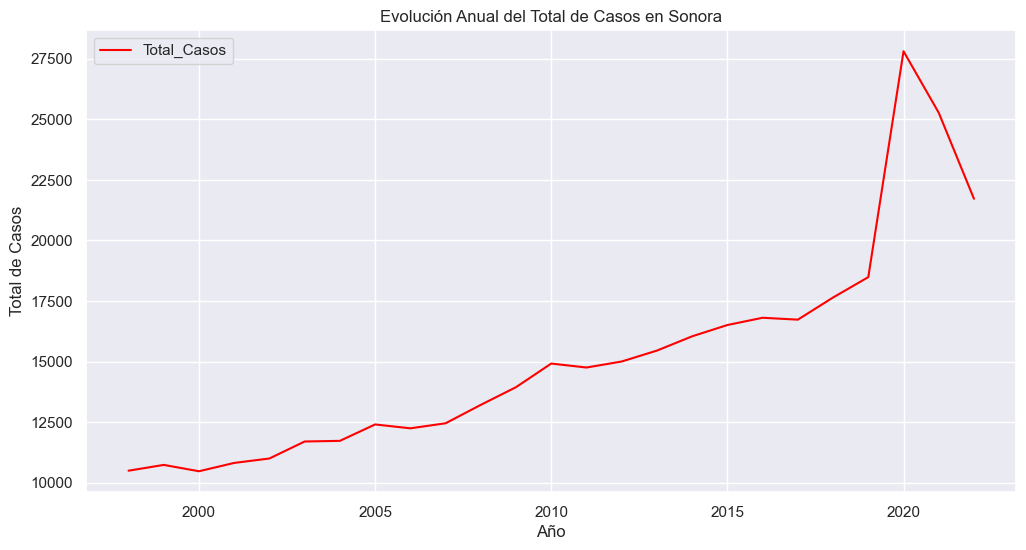

In [77]:
# 3. Evolución anual del total de casos en Sonora
query = "SELECT YEAR(`Año`) AS Año, SUM(`Total`) AS Total_Casos FROM defunciones_sexo_porentidad WHERE `Entidad_Federativa` = 'Sonora' GROUP BY YEAR(`Año`) ORDER BY Año;"
evolucion_sonora = fetch_data(query)
evolucion_sonora['Total_Casos'] = evolucion_sonora['Total_Casos'].astype('int64')
evolucion_sonora
evolucion_sonora.plot(title='Evolución Anual del Total de Casos en Sonora',x='Año', y='Total_Casos',color='red')
plt.xlabel('Año')
plt.ylabel('Total de Casos')
plt.show()

Se observa un crecimiento abrupto del año 2019 al año 2020, y el motivo que podríamos inferir, es la llegada del COVID-19 ya que justo entre esos años apareció, así que probablemente, ese es el motivo de ese crecimiento repentino, haría falta corroborar eso, con la base de datos de las principales causas de defunciones por año para completar el análisis.

## **Reflexión**
En este proyecto, nos enfocamos en analizar el comportamiento de los datos en 2022, particularizando para el estado de Sonora, dentro de las cosas que se pudieron observar están

1. **Casos de decesos en general**: Observamos una cantidad alta de decesos para este año, sin embargo, el Estado de México rebasa por 3/10 partes al segundo lugar en muertes (Ciudad de México), mientras que la diferencia entre los demás estados es mucho más pequeña.

2. **Distribución por Género**: En la mayoría de las entidades, hay una tendencia a tener más casos reportados para hombres que para mujeres.

3. **Sonora**: Enfocándonos en Sonora, notamos que el total de casos ha tenido una tendencia variable pero creciente a lo largo de los años, aunque del año 2020 al 2022 decrece la cantidad de defunciones. En cuanto a la distribución por género, muestra una proporción relativamente equilibrada pero con una ligera predominancia en casos de hombres.